<a href="https://colab.research.google.com/github/Artemiy2708/ML/blob/main/%F0%9F%90%AFX_AKA_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href=https://www.hse.ru/ target="_blank">HSE</a> 2021 onwards</font></small><hr style="margin:0;background-color:silver">

# **[🏆🎞️MovieGenres](https://www.kaggle.com/competitions/oct312022moviegenres/rules)** <small>(See private URL in LMS assignment)</small>

See [**instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running and naming your Colab notebooks.



**(Optioal) CONSENT.** If ok with sharing your Colab for educational purposes, please check the box below with "X".

<mark>[ . . ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purpose. We understand that sharing is optional and this decision will not affect our grade in any way. 

In [ ]:
 from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install -U sentence-transformers > log    # install sentence BERT text encoder
!pip -q install -U --force-reinstall --no-deps kaggle >> log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >>log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json >> log      # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v oct312022moviegenres   # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: oct312022moviegenres
Using competition: oct312022moviegenres
 teamId  teamName                       submissionDate       score    
-------  -----------------------------  -------------------  -------  
9407000  🐯B-NNY-Kudr,Oreshin,Shalamova  2022-11-12 22:21:38  0.92697  
9420438  🐯E-WhereIsTheMarkLebowski      2022-11-11 17:52:52  0.92181  
9440142  🐯D-ScalaJSON-Aver,Svir,Maly    2022-11-13 10:28:04  0.91952  
9449049  🐯G-Ivanov                      2022-11-13 20:14:26  0.91611  
9445484  🐯F-NaN-Pugin,Borisov           2022-11-11 11:38:24  0.91552  
9448666  🐯N-Voronina,Asharin,Almasya    2022-11-13 16:24:49  0.91552  
9448585  🐯V-Pak, Zondberg, Ivanov       2022-11-13 15:19:02  0.91552  
9445076  🐯X-AKA                         2022-11-13 16:25:50  0.91548  
9448152  🐯S-Alkhanash,Barinov,Morozova  2022-11-13 14:10:15  0.91519  
9419878  🐯Q-SAS                         2022-11-12 09:28:09  0.91482  
9

In [ ]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import pandas as pd, numpy as np, matplotlib.pyplot as plt, plotly, time
from sklearn.model_selection import train_test_split  # the only allowed function from sklearn
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import RadiusNeighborsClassifier
from sentence_transformers import SentenceTransformer as SBERT  # to encode multilingual text into numeric vectors

pd.set_option('max_rows', 5, 'max_columns', 100, 'max_colwidth', 30, 'precision', 2)
np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

XY = pd.read_csv('MovieGenresXY.csv')
nClass = 20                                         # number of output classes/genres
YCols = XY.columns[-nClass:]                        # 20 output columns - movie genre indicators
XNumCols = XY.select_dtypes(include=np.number).drop(YCols, axis=1).columns  # numeric column names
XY[XNumCols] = XY[XNumCols].fillna(0)               # fill numeric columns with zeros
XY['desc'] = XY.overview + '.' + XY.title + '. ' + XY.original_language + '. ' + XY.keywords + '. ' + XY.tagline
vX = XY.query('Action!=Action').drop(YCols, axis=1) # test inputs, movie attributes
tXY = XY.query('Action==Action')                    # training I/O
tX, tY = tXY.drop(YCols, axis=1), tXY[YCols]        # split into training I/O
vX, tX = vX.fillna('na'), tX.fillna('na')           # textual fields are filled with NA text
XY

,budget,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,desc
0,16000000,NaN,"[{""id"": 907, ""name"": ""japa...",en,Hachi: A Dog's Tale,A drama based on the true ...,43.22,"[{""name"": ""Grand Army Ente...","[{""iso_3166_1"": ""GB"", ""nam...",2009-06-13,47801389,93.0,"[{""iso_639_1"": ""en"", ""name...",Released,"A true story of faith, dev...",Hachi: A Dog's Tale,7.7,1717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A drama based on the true ...
1,5500000,NaN,"[{""id"": 520, ""name"": ""chic...",en,The Sting,Set in the 1930's this int...,28.50,"[{""name"": ""Universal Pictu...","[{""iso_3166_1"": ""US"", ""nam...",1973-12-25,159616327,129.0,"[{""iso_639_1"": ""en"", ""name...",Released,...all it takes is a littl...,The Sting,7.9,622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Set in the 1930's this int...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4801,15000000,http://www.biglebowskiblur...,"[{""id"": 418, ""name"": ""whit...",en,The Big Lebowski,"Jeffrey ""The Dude"" Lebowsk...",49.23,"[{""name"": ""Gramercy Pictur...","[{""iso_3166_1"": ""GB"", ""nam...",1998-03-06,46189568,117.0,"[{""iso_639_1"": ""en"", ""name...",Released,Times like these call for ...,The Big Lebowski,7.8,2926,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Jeffrey ""The Dude"" Lebowsk..."
4802,13000000,NaN,"[{""id"": 4118, ""name"": ""bal...",en,Save the Last Dance,A white midwestern girl mo...,9.97,"[{""name"": ""MTV Films"", ""id...","[{""iso_3166_1"": ""US"", ""nam...",2001-01-12,91038276,112.0,"[{""iso_639_1"": ""en"", ""name...",Released,The Only Person You Need T...,Save the Last Dance,6.3,352,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,A white midwestern girl mo...


In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import f1_score 

In [ ]:
%time sbert = SBERT('all-mpnet-base-v2')  # load SBERT embedings model to encode textual fields

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

CPU times: user 14.7 s, sys: 2.51 s, total: 17.2 s
Wall time: 50 s


In [ ]:
tX.drop('revenue', axis=1, inplace=True)
vX.drop('revenue', axis=1, inplace=True)
tX.drop('popularity', axis=1, inplace=True)
vX.drop('popularity', axis=1, inplace=True)
tX.drop('vote_count', axis=1, inplace=True)
vX.drop('vote_count', axis=1, inplace=True)
XY.drop('revenue', axis=1, inplace=True)
XY.drop('vote_count', axis=1, inplace=True)
XY.drop('popularity', axis=1, inplace=True)
XNumCols=XNumCols.drop('revenue')
XNumCols=XNumCols.drop('vote_count')
XNumCols=XNumCols.drop('popularity')

In [ ]:
%time tXEmb = np.c_[tX[XNumCols].values, sbert.encode(tX.desc.tolist())] # Set GPU runtime in Colab for 10-100x speed up
%time vXEmb = np.c_[vX[XNumCols].values, sbert.encode(vX.desc)]
print(f'Train embedding matrix size:', tXEmb.shape)
pd.DataFrame(tXEmb[:3,:20], index=tXY.title[:3]).style.background_gradient(cmap='coolwarm')  # show movie description and a few of its embedding features

CPU times: user 30min 20s, sys: 16.7 s, total: 30min 37s
Wall time: 30min 39s
CPU times: user 30min 1s, sys: 15.6 s, total: 30min 17s
Wall time: 30min 17s
Train embedding matrix size: (2401, 771)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
title,,,,,,,,,,,,,,,,,,,,
The Midnight Meat Train,15000000.00,98.00,6.00,0.03,0.04,0.01,0.06,-0.04,0.01,0.02,0.01,-0.13,0.01,0.02,0.03,-0.00,-0.04,0.01,-0.04,-0.06
London to Brighton,0.00,85.00,6.50,0.01,0.02,-0.01,0.00,-0.04,0.03,0.01,0.00,-0.07,0.01,-0.00,-0.04,0.05,0.04,-0.01,-0.03,0.02
The Wash,7000000.00,93.00,5.30,0.01,0.05,-0.02,-0.01,-0.01,0.02,-0.01,-0.01,-0.02,-0.01,-0.01,0.04,0.03,0.04,-0.01,0.06,-0.01


In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**
We changed the SBERT model encoder for the best possible(avg score) on the website you provided. Then we draw matrix multicollinearity and was that for there were come higly collinear features in groups- we dropped one from each group. After the transformation we tried to make polynomial fetarure for ridge classifier() , but after encoding we left too much features 771 , so it just impossible to run here in collab and ineefective. ALso we tried pca- it didn't worked out, score dropeed 0.02 for metric. We did not try firstly apply pca then make polynomial features of others, as they have different approaches , one reducing dimesionality , another incresing- that is just strange.

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**
We tuned parametres(alpha) for ridge classifier cv, applying the for loop for right metric evaluation gere in collab( for each feature itself), adding to a dataframe, then calculating mean, reaching 0.91500 metric score. Also we tried other models, each of them showed surprisingly less performance as ridge classifier. Random forest with tuning max depth , number of estimatirs did not even reach 0.9, while knn highly reached 0.88. Then, our expectances were on boosting , because it was stated many times that RF is better version of Bagging due to higher uniqeness of tress in bootstrap(becase of random subsample of features used, not all like in classoccal bagging), and boosting is iteratively corrects mistakes of previous trees and has higher performance usually. We reahed slightly higher than 0.9 by applying boosign, trying tuning the parmetres of learning rate, but it was far worse still the ridge classifier. We did not have time to check logistic regression and extra tree classifier.

Below is a baseline model that produces the result on Kaggle leaderboard (LB).

[SBERT](https://www.sbert.net) generates 384-dimensional text embedding vectors for each movie's description. See [more models](https://www.sbert.net/docs/pretrained_models.html). Use GPU runtime in Colab for 10-100x speed up.

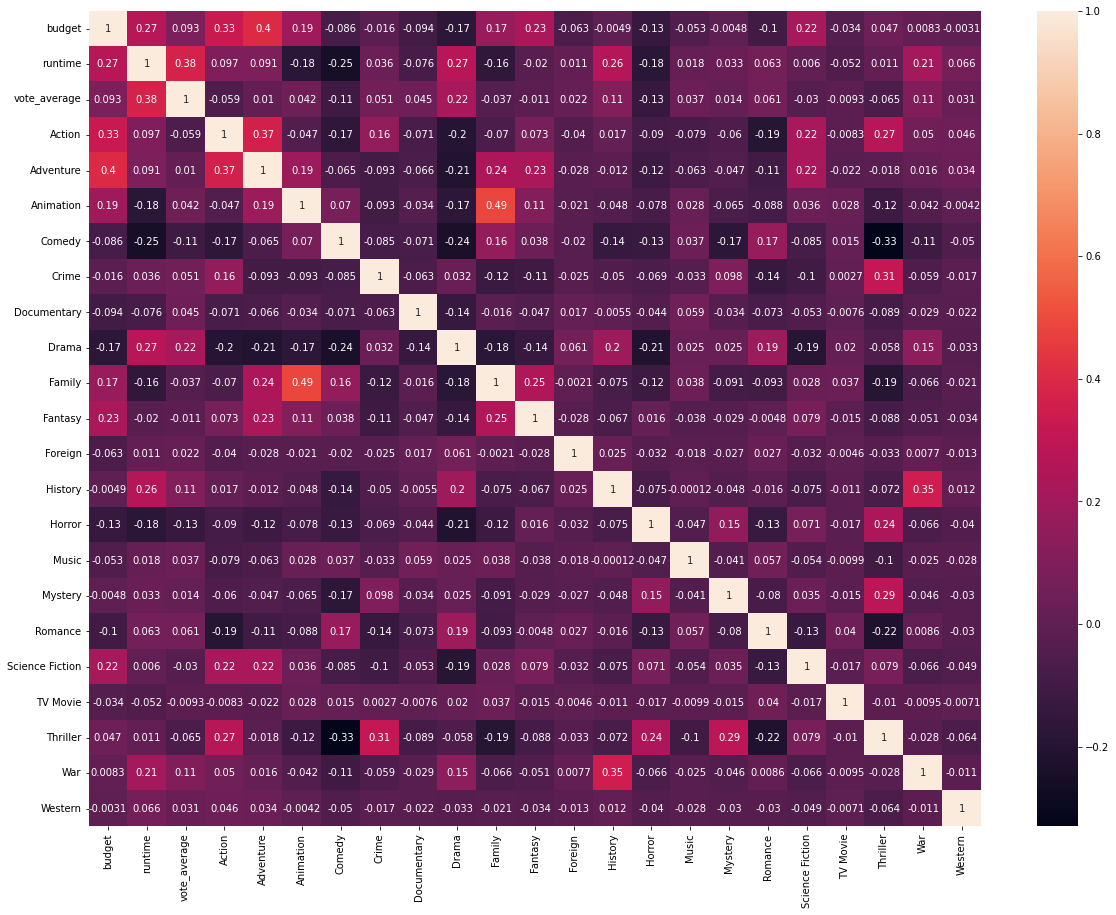

In [ ]:
#import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 15];  
#sns.heatmap(XY.corr(), annot = True);


In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures as Poly
#poly=Poly(2)
m = RidgeClassifier(alpha=[0.54])  # multi-label model
f1=[]
for i in YCols:
  txemb,vxemb,ty,vy=train_test_split(tXEmb,tY[i], train_size=0.8, random_state=1)
 # txemb=poly.fit_transform(txemb)
  #vxemb=poly.transform(vxemb)
  m.fit(txemb,ty)
  prediction = m.predict(vxemb)
  f1.append(f1_score(prediction,vy, average='micro'))        
np.mean(f1)     

m.fit(tXEmb,tY) # fitting to training I/O
                          

NameError: ignored

In [ ]:
pY = pd.DataFrame(m.predict(vXEmb), index=range(len(vX)), columns=YCols)  # Don't shuffle observations. Keep original order with index 0,1,2,...
pd.DataFrame(pY.values[:20,:], index=vX.title[:20], columns=YCols).style.background_gradient(cmap='coolwarm', axis=1)
pY.reset_index().rename(columns={'index':'id'}).to_csv('Baseline.csv', index=False)  # baseline submission with 0-1 values for class memembership

NameError: ignored

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier as GBC

In [ ]:
#m1 = GBC(random_state=0,n_estimators=200, learning_rate=0.01)  # multi-label model
#f1=[]
#for i in YCols:
  #txemb,vxemb,ty,vy=train_test_split(tXEmb, tY[i], train_size=0.8, random_state=0)
  #m1.fit(txemb,ty)
  #prediction = m1.predict(vxemb)
  #f1.append(f1_score(prediction,vy, average='micro'))        
#np.mean(f1)      # fitting to training I/O

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200, random_state=0)

0.9013513513513514

In [ ]:
#m2 = KNC(n_neighbors=3)  # multi-label model
#f1=[]
#for i in YCols:
 # txemb,vxemb,ty,vy=train_test_split(tXEmb, tY[i], train_size=0.8, random_state=0)
  #m2.fit(txemb,ty)
  #prediction = m2.predict(vxemb)
  #f1.append(f1_score(prediction,vy, average='micro'))        
#np.mean(f1)      # fitting to training I/O           # fitting to training I/O

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=120)

0.8808731808731809

In [ ]:
##pY = pd.DataFrame(m1.predict(vXEmb), index=range(len(vX)), columns=YCols)  # Don't shuffle observations. Keep original order with index 0,1,2,...
#pd.DataFrame(pY.values[:10,:], index=vX.title[:10], columns=YCols).style.background_gradient(cmap='coolwarm', axis=1)
#pY.reset_index().rename(columns={'index':'id'}).to_csv('Baseline (Python).csv', index=False)  # baseline submission with 0-1 values for class memembership

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
Hachi: A Dog's Tale,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
The Sting,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
The Book of Life,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"Dude, Where’s My Car?",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Bolt,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Saw IV,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
Hall Pass,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
The Ladies Man,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Jingle All the Way,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
#pY = pd.DataFrame(m2.predict(vXEmb), index=range(len(vX)), columns=YCols)  # Don't shuffle observations. Keep original order with index 0,1,2,...
#pd.DataFrame(pY.values[:20,:], index=vX.title[:20], columns=YCols).style.background_gradient(cmap='coolwarm', axis=1)
#pY.reset_index().rename(columns={'index':'id'}).to_csv('Baseline.csv', index=False)  # baseline submission with 0-1 values for class memembership

ValueError: ignored

In [ ]:
pY

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#!kaggle competitions submit -c oct312022moviegenres -f Baseline.csv -m «comment»

100% 105k/105k [00:00<00:00, 117kB/s]
Successfully submitted to Oct31,2022🏆🎞️MovieGenres

# **References:**

1. https://hastie.su.domains/ISLR2/ISLRv2_website.pdf

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 30 sec


# 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions and polynomial features for the original numeric features. Then identify key features or select key principal components. The final model can be trained on a larger or even full training sample. You can use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature set
1. Do a thorough EDA: look for feature augmentations that result in suitable decision boundaries between pairs of classes (for example, linear boundary for linear models).
1. Evaluate predictions and focus on poorly predicted "groups":
  1. Strongest misclassifications. E.g. the model is very confident about the wrong label
  1. Evaluate predictions near decision boundaries. Is there a way to separate mixed points near the boundary by, perhaps, introducing additional dimensions or interactions?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support, or can the pattern be linearized via transformations?
1. Clean up textual fields to remove uninformative text. For example, you can use [`json`](https://docs.python.org/3/library/json.html) and [`re`](https://docs.python.org/3/library/re.html) to retrieve just keywords from the lists of [JSON](https://en.wikipedia.org/wiki/JSON) keywords. This may speed up embeddings and lower noise in output coefficients.
   1. Example: `'[{"id": 907, "name": "japanese"}, ...'` $\to$ `'japanese, loyalty, friendship, ...'`
1. Fill input `NA`'s with more suitable statistic (for example, column or group mean or median)
1. Replaces extreme numeric values (such as zeros) with some statistic (such as mean/median) or a modeled value or `NA` (if the predictive model can handle `NA` inputs)
1. Consider embedding other textual fields, if they appear to relate to genres. For example, some countries or companies may focus on documentaries or on action films
1. Try to find a more [suitable SBERT embedding](https://www.sbert.net/docs/pretrained_models.html
1. Consider embedding "important" (for prediction) textual fields separately and concatenating or summing their vectors.
) (small, fast, trained on related text)
1. Learn about [TMDB](https://www.themoviedb.org/) dataset and [related models](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=tmdb+machine+learning+model&btnG=).
